In [1]:
%matplotlib inline
import torch
from models.rpca import RobustPCA
from models.rda import RobustDeepAutoencoder
from evaluation.eval import evaluate_models
from data.filteredDataset import FilteredDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from trainers.trainer import get_trainer

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 50
IMG_SIZE = 168
FOOTAGE_ID = "hall1" 

In [3]:
print(f"Using device: {DEVICE}\n")

if __name__ == "__main__":
    transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
        ])
    
    i2r_data = FilteredDataset(
        root="./datasets/I2R_Frames",
        transform=transform,
        target_class=FOOTAGE_ID
    )
    i2r_loader = DataLoader(
        i2r_data,
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    
    test_loader = DataLoader(
        i2r_data,
        batch_size=len(i2r_data),
        shuffle=False
    )

Using device: cuda

Filtered dataset for Class 'hall1' (ID 9): 200 images.


In [4]:
ae_params = {
        'latent_dim': 8,
        'dropout': 0.33,
        'std': 0.5,
        'lr': 2e-4,
        'lambda_': 0.003,
        'outer_epochs': 4,
        'inner_epochs': 15,
    }

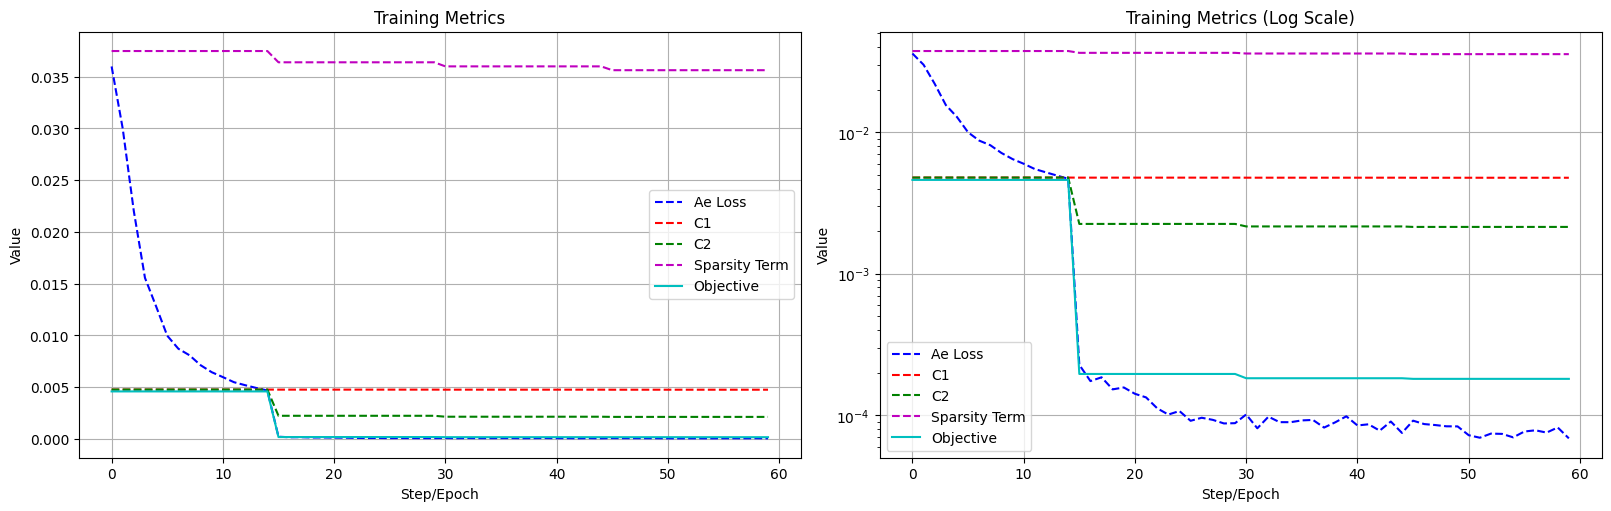

ADMM Steps: 100%|██████████| 4/4 [02:12<00:00, 33.09s/it, Obj=1.8e-04, L_Rec=7.4e-05, Sparse=3.6e-02, S%=92.8%]

Final Reconstruction Loss: 6.8588e-05
ADMM Training Complete.


In [5]:
models_dict = {}
rpca = RobustPCA(max_iter=6000, lambda_=None, tol=1e-7).to(DEVICE) 
ae = RobustDeepAutoencoder(latent_dim=ae_params['latent_dim'], dropout=ae_params['dropout'], std=ae_params['std']).to(DEVICE)
print(f"Using parameters: {ae_params}\n")

trainer = get_trainer('RDA', ae, i2r_loader)

trainer.fit(
        outer_epochs=ae_params['outer_epochs'], 
        inner_epochs=ae_params['inner_epochs'],
        lr=ae_params['lr'],
        lambda_=ae_params['lambda_']
    )
models_dict['RDA'] = ae

In [ ]:
evaluate_models(test_loader, rpca, models_dict, subject_id=FOOTAGE_ID, results_root="./results/i2r")


Evaluating on batch of size 200...
Found pre-computed RPCA results. Loading from disk...
Running Deep Models Inference...
Inference done.



In [ ]:
print("Do you want to save the trained Autoencoder model? (y/n): ", end="")
save_choice = input().strip().lower()
if save_choice == 'y':
    model_name = "rda_model_i2r_3"
    torch.save(ae.state_dict(), f"{model_name}.pth")
    print(f"Model saved as {model_name}.pth")
else:
    print("Model not saved.")